<!-- Step 1. 인물모드 직접 해 보기
여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요? -->

### Step 1. 인물모드 직접 해 보기


In [25]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/02.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)


(720, 1280, 3)


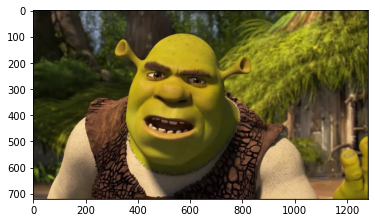

In [26]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [27]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7a633ccc1a60>)

In [28]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file) 

In [29]:
segvalues, output = model.segmentAsPascalvoc(img_path) 

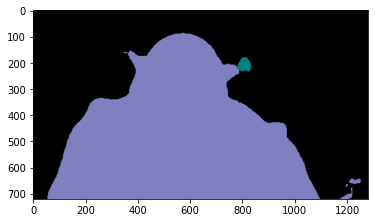

In [30]:
plt.imshow(output)
plt.show()

In [32]:
import os

res_list = []
segvalues_lst = []
img_lst = []
def iterate_sunglass_img(folder_path):
    for file_name in os.listdir(folder_path):  
        file_path = os.path.join(folder_path, file_name) 
        print(file_path)
        if file_path.endswith('.jpg'):
            img_lst.append(file_path)
            segvalues, output = model.segmentAsPascalvoc(file_path) 
            segvalues_lst.append(segvalues)
            res_list.append(output)
    return res_list
base_dir = "/aiffel/aiffel/human_segmentation/images" 
res = iterate_sunglass_img(base_dir)


/aiffel/aiffel/human_segmentation/images/03.jpg
/aiffel/aiffel/human_segmentation/images/05.jpg
/aiffel/aiffel/human_segmentation/images/02.jpg
/aiffel/aiffel/human_segmentation/images/04.jpg
/aiffel/aiffel/human_segmentation/images/.ipynb_checkpoints


In [40]:
len(res)

4

In [41]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

for segvalues in segvalues_lst:
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])
    print('\n')

background
bottle
diningtable
person


background
person


background
bird
person


background
bottle
person




In [42]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [43]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
colormap[15]

array([192, 128, 128])

(720, 1280)


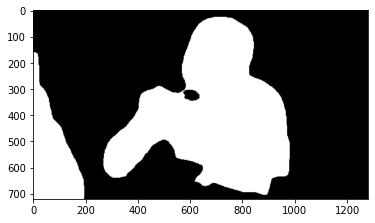

(1080, 885)


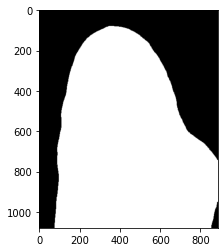

(720, 1280)


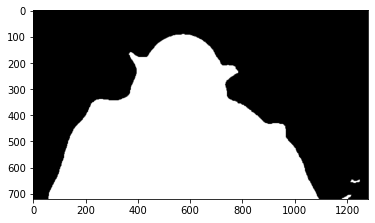

(685, 1300)


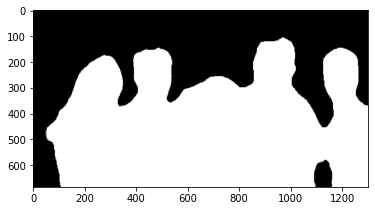

In [44]:
seg_map_lst = []
for output in res_list:
    seg_map = np.all(output==seg_color, axis=-1) 
    seg_map_lst.append(seg_map)
    print(seg_map.shape) 
    plt.imshow(seg_map, cmap='gray')
    plt.show()


In [38]:
for img_path in img_lst:
    print(img_path)

/aiffel/aiffel/human_segmentation/images/03.jpg
/aiffel/aiffel/human_segmentation/images/05.jpg
/aiffel/aiffel/human_segmentation/images/02.jpg
/aiffel/aiffel/human_segmentation/images/04.jpg


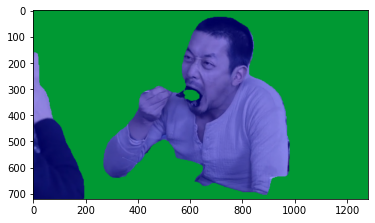

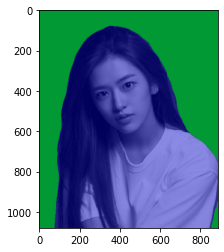

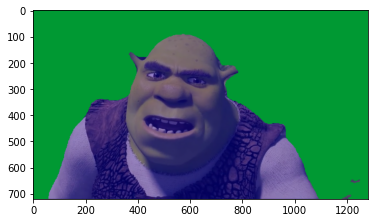

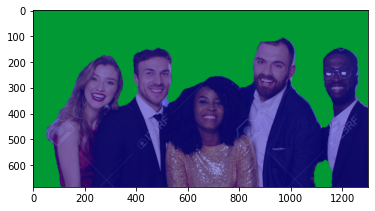

In [47]:
# 원본이미지를 img_show에 할당한뒤 이미지 객채 위치와 배경을 분리해서 표현한 color_mask 를 만들고 이미지를 합쳐서 출력
for i in range(len(img_lst)):
# for img_path in img_lst:
    img_show = cv2.imread(img_lst[i]).copy()
    seg_map = seg_map_lst[i]

    # True과 False인 값을 각각 25, 0
    img_mask = seg_map.astype(np.uint8) * 25
    img_mask = cv2.resize(img_mask, (img_show.shape[1], img_show.shape[0]))

    # 객체(1)과 배경(0)을 구분
    seg_map = np.stack([seg_map] * 3, axis=-1)

    # 배경을 초록색으로 설정
    green_background = np.full_like(img_show, (0, 255, 0), dtype=np.uint8)
    # 배경을 초록색으로 변경
    img_show = np.where(seg_map == 1, img_show, green_background)

    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 0.6과 0.4는 이미지를 섞는 비율
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

### Step 2. 사진에서 문제점 찾기

1. 슈랙을 인간 라벨링으로 할당되면서, 사람에게서 보기 힘든 귀의 일부 모양이 나비로 라벨링 잡히었다. \\
 - ![image](/aiffel/aiffel/human_segmentation/images/res1.png)  

2. 두번째로 하정우 배우의 어깨 일부가 포함되지 않은 것이 눈에 띈다. 손, 수저, 얼굴윤곽으로 엣지 경계가 신체와 완전히 구분되었을때 포함되지 않았다.\\
 - ![image](/aiffel/aiffel/human_segmentation/images/res2.png)  

3. 엣지 경계가 명확하지 않았다.


### Step 3. 해결 방법을 제안해 보기

 -  초점이 맞는 부분과 흐림을 구분하는 데 있어서 정확한 구분이 이루어지지 않으면 자연스러운 세그멘테이션에 어려움이 있을 수 있다.
    엣지 경계부분은 세그멘테이션 정확도가 낮은 영역에서는 보케(아웃포커싱) 효과를 덜 적용하거나 다른 보정을 해서 더욱 자연스럽게 처리할 수 있을 것이다.  
 -  새로운 레이블에 대한 추가 학습이 필요할 수 있다.
 *  Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.